# 一番良い結果を出したモデルに関して、テスト画像を各クラス一枚づつ可視化。

In [30]:
# imports
import glob
import os
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

from keras import activations
from keras.utils import np_utils
from keras.models import model_from_json

from vis.utils import utils
from vis.visualization import overlay, visualize_saliency
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ================ Parameter Setting ====================

DATA_DIR = os.getenv("HOME") + "/data/toray/typeD/Ibutu_kizu"

# Dataset parameter
img_width, img_height = 250, 250

# Class dictionary
class_dic = {0: 'ibutu', 1:'kizu(kohen)', 2:'kizu(seimitu)', 3:'kizu(simu)', 4:'yogore'}

# ================= Parameter End ========================

In [3]:
# function for loading data and preprocessing
def data():
    file_path_list = sorted(glob.glob(os.getenv("HOME") + "/data/toray/typeD/Ibutu_kizu/*/*.JPG"))
    
    X = [np.asarray(Image.open(file_path).resize((250, 250))) for file_path in file_path_list]

    labels = [os.path.split(os.path.split(file_path)[0])[1]
              for file_path in file_path_list]
    categories = sorted(list(set(labels)))
    Y = [categories.index(label) for label in labels]

    # list => numpy
    X = np.asarray(X, dtype=np.float32)
    Y = np.asarray(Y)
    
    X /= 255
    
    X_train = np.concatenate((X[np.where(Y == 0)][100:288],
                              X[np.where(Y == 1)][100:288],
                              X[np.where(Y == 2)][100:288],
                              X[np.where(Y == 3)][100:288],
                              X[np.where(Y == 4)][100:288]), axis=0)
    X_test = np.concatenate((X[np.where(Y == 0)][:100],
                             X[np.where(Y == 1)][:100],
                             X[np.where(Y == 2)][:100],
                             X[np.where(Y == 3)][:100],
                             X[np.where(Y == 4)][:100]), axis=0)

    Y_train = np.concatenate((Y[np.where(Y == 0)][100:288],
                              Y[np.where(Y == 1)][100:288],
                              Y[np.where(Y == 2)][100:288],
                              Y[np.where(Y == 3)][100:288],
                              Y[np.where(Y == 4)][100:288]), axis=0)
    Y_test = np.concatenate((Y[np.where(Y == 0)][:100], 
                             Y[np.where(Y == 1)][:100], 
                             Y[np.where(Y == 2)][:100],
                             Y[np.where(Y == 3)][:100], 
                             Y[np.where(Y == 4)][:100]), axis=0)
    
    # one-hot
    Y_train = np_utils.to_categorical(Y_train, 5)
    Y_test = np_utils.to_categorical(Y_test, 5)
    
    # Shuffle train dataset(important)
    X_train, Y_train = shuffle(X_train, Y_train)
    
    # Show shape
    print("X_train.shape: {0}".format(X_train.shape))
    print("Y_train.shape: {0}".format(Y_train.shape))
    print("X_test.shape: {0}".format(X_test.shape))
    print("Y_test.shape: {0}".format(Y_test.shape))
    
    return X_train, Y_train, X_test, Y_test

In [10]:
# Load and preprocess dataset
X_train, Y_train, X_test, Y_test = data()

X_train.shape: (940, 250, 250, 3)
Y_train.shape: (940, 5)
X_test.shape: (500, 250, 250, 3)
Y_test.shape: (500, 5)


In [11]:
# Load trained model from directry
Xception_model = model_from_json(open('best_model_weights/Xception_model.json').read())
Xception_model.load_weights('best_model_weights/Xception_weights.h5')

# modelの評価

In [14]:
# Evaluate confusion-matrix and f-score
y_pred = Xception_model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, -1)
y_true = np.argmax(Y_test, -1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

500/500 [==============================] - 320s    
[[92  0  4  4  0]
 [ 0 89  4  7  0]
 [ 0  0 99  1  0]
 [ 5  0 18 77  0]
 [ 2  0  2  1 95]]
             precision    recall  f1-score   support

          0       0.93      0.92      0.92       100
          1       1.00      0.89      0.94       100
          2       0.78      0.99      0.87       100
          3       0.86      0.77      0.81       100
          4       1.00      0.95      0.97       100

avg / total       0.91      0.90      0.90       500



# 可視化

In [15]:
# Swap softmax with linear
Xception_model.layers[-1].activation = activations.linear
Xception_model = utils.apply_modifications(Xception_model)

/Users/akira/.pyenv/versions/3.6.0/envs/toray_project/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


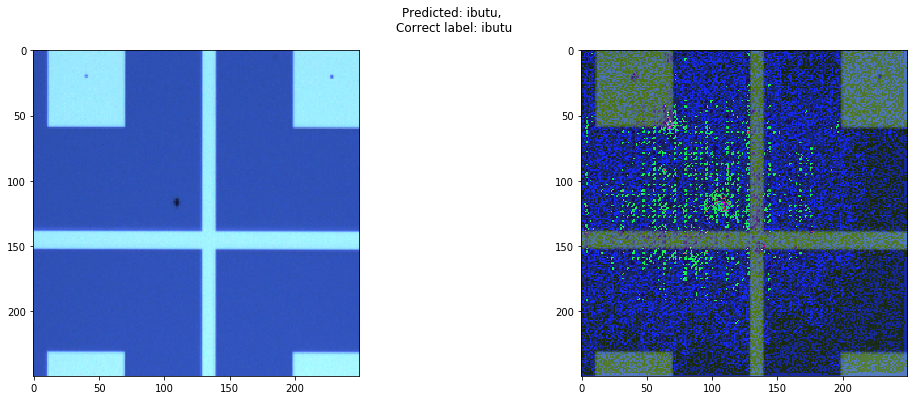

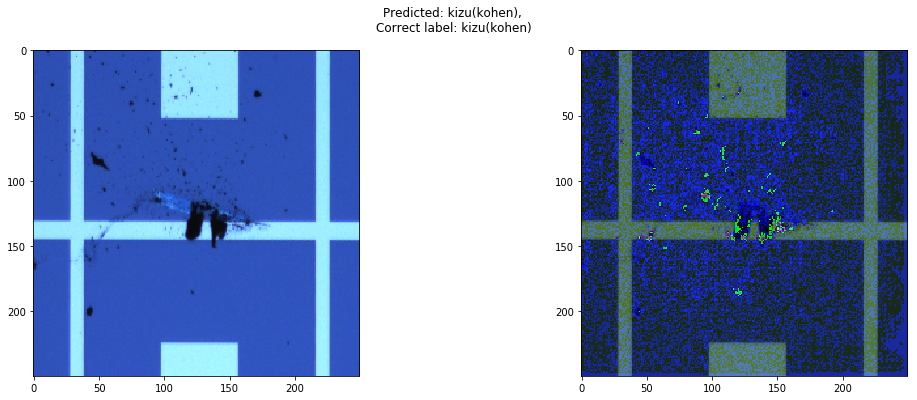

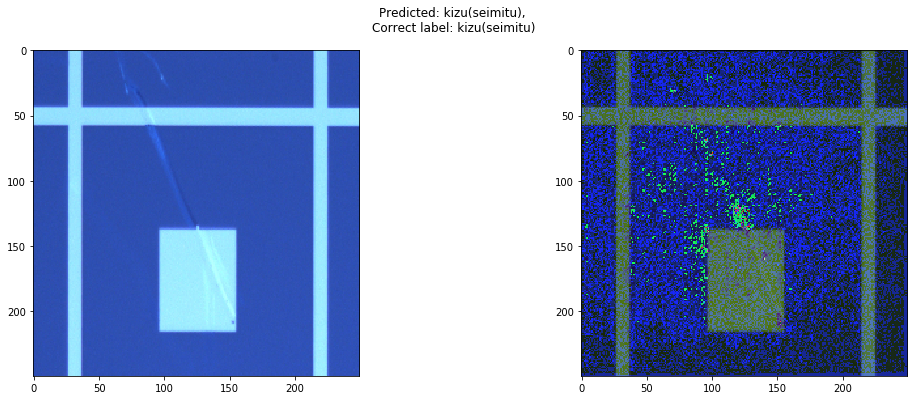

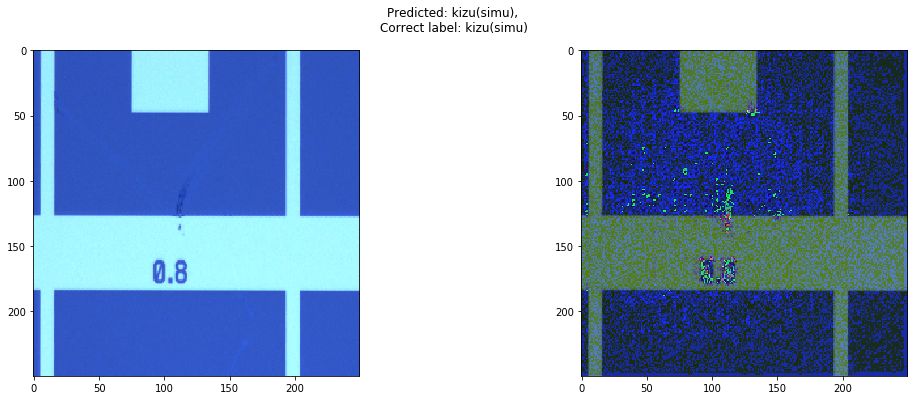

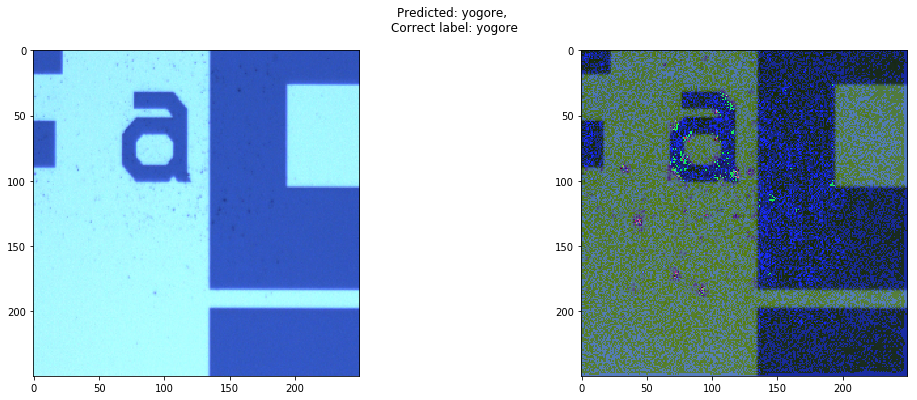

In [44]:
# set window size
plt.rcParams['figure.figsize'] = (18, 6)

# show original and heatmaped images of each test data
for img, onehot_label in zip(X_test[::100], Y_test[::100]):    
    plt.figure()
    
    # get prediction
    img_re = np.reshape(img, (1, 250, 250, 3))
    top_idx = np.argmax(Xception_model.predict(img_re, batch_size=1, verbose=0))
    
    # get correct label
    label = np.argmax(onehot_label)
    
    # get heatmap of each image
    heatmap = visualize_saliency(Xception_model, -1, filter_indices=top_idx, 
                                 seed_input=img, backprop_modifier='relu')
    
    # Lets overlay the heatmap onto original image.
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(overlay(img, heatmap))
    plt.suptitle('Predicted: {0}, \nCorrect label: {1}'.format(class_dic[top_idx], class_dic[label]))